In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input/waveform-inversion/train_samples/'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler

import matplotlib.pyplot as plt
import tqdm
from glob import glob

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


In [3]:
def scale_target(target_raw):
    target_raw_min = 1500.0 
    target_raw_max = 4500.0
    target_scaled = (target_raw - target_raw.min())/(target_raw.max() - target_raw.min())
    return target_scaled, target_raw_min, target_raw_max
def scale_data(data_raw):
    t = np.linspace(0,999,1000)
    dump = 1000*np.exp(- t / 150)
    data_scaled_min = -1.3679967
    data_scaled_max = 1.917767
    data_scaled = data_raw / dump.reshape(1, 1, 1000, 1)
    data_scaled = (((data_scaled_min)-data_scaled) / (data_scaled_max - data_scaled_min)+0.5)*2
    return data_scaled

In [4]:
class DataLoader():
    def __init__(self):
        self.folder = 'Data\\'
        self.n_processed = 0

    def load_data(self, dirname:str, datafiles: list, targetfiles:list):
        data_list = []
        for datafile in datafiles:
            data_list += [scale_data(np.load(dirname+datafile))]
        data = np.concatenate(data_list, axis=0)
        target_list = []
        for targetfile in targetfiles:
            target_list += [scale_target(np.load(dirname+targetfile))[0]]
        target = np.concatenate(target_list, axis=0)
        return data, target
    def get_train_set(self, fast=False):
        for dirname in os.listdir(self.folder ):
            if fast and 'FlatFault' not in dirname:
                continue
            content = sorted( os.listdir(self.folder + dirname))
            #print(content)
            data_files = []
            target_files = []
            if 'data' in content:
                data_files = ['/data/'+f for f in sorted(os.listdir(self.folder + dirname + '/data'))]
                target_files = ['/model/'+f for f in sorted(os.listdir(self.folder + dirname + '/model'))]
            else:
                data_files = ['/' + f for f in content if f.startswith('seis')]
                target_files = ['/' + f for f in content if f.startswith('vel')]
            #print('data', data_files)
            #print('target', target_files)
            self.n_processed += 1
            yield self.load_data(self.folder + dirname, data_files, target_files)   



In [5]:
class CNNAutoencoder(nn.Module):
    def __init__(self, latent_dim=1024):
        super(CNNAutoencoder, self).__init__()
        
        # Encoder
        k1 = 8
        k2 = 16
        k3 = 32
        k4 = 64
        self.encoder = nn.Sequential(
            # First convolutional block
            nn.Conv2d(5, k1, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(k1),
            nn.Sigmoid(),
            
            # Second convolutional block
            nn.Conv2d(k1, k2, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(k2),
            nn.ReLU(True),
            
            # Third convolutional block
            nn.Conv2d(k2, k3, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(k3),
            nn.ReLU(True),
            
            # Final encoding layer
            nn.Conv2d(k3, k4, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(k4),
            nn.ReLU(True),

            nn.Flatten(),
            
            nn.Linear(k4*125*9, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU(True),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, k4*9*9),
            nn.BatchNorm1d(k4*9*9),
            nn.ReLU(True),
            
            nn.Unflatten(1, (k4,9,9)),
            
            # First transposed conv block
            nn.ConvTranspose2d(k4, k3, kernel_size=3, stride=1, padding=1),  # 9x9 -> 9x9
            nn.BatchNorm2d(k3),
            nn.ReLU(True),
            
            # Second transposed conv block
            nn.ConvTranspose2d(k3, k2, kernel_size=3, stride=2, padding=1, output_padding=1),  # 9x9 -> 18x18
            nn.BatchNorm2d(k2),
            nn.ReLU(True),
            
            # Third transposed conv block
            nn.ConvTranspose2d(k2, k1, kernel_size=3, stride=2, padding=1),  # 18x18 -> 35x35
            nn.BatchNorm2d(k1),
            nn.ReLU(True),
            
            # Final transposed conv block
            nn.ConvTranspose2d(k1, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 35x35 -> 70x70
            nn.Sigmoid()  # Ensures output is between 0 and 1
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)

In [5]:
class CNNAutoencoderV2(nn.Module):
    def __init__(self, latent_dim=1024):
        super(CNNAutoencoderV2, self).__init__()
        
        drop = 0.
        # Encoder
        k1 = 4
        k2 = 8
        k3 = 32
        k4 = 16
        k5 = 128
        k6 = 16
        k7 = 4
        self.encoder = nn.Sequential(
            # First convolutional block
            nn.Conv2d(5, k1, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(k1),
            nn.Sigmoid(),
            
            # Second convolutional block
            nn.Conv2d(k1, k2, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(k2),
            nn.ReLU(True),
            nn.Dropout2d(drop),
            
            # Third convolutional block
            nn.Conv2d(k2, k3, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(k3),
            nn.ReLU(True),
            nn.Dropout2d(drop),
            
            # Final encoding layer
            nn.Conv2d(k3, k4, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(k4),
            nn.ReLU(True),
            nn.Dropout2d(drop),

            nn.Flatten(),
            
            nn.Linear(k4*125*9, latent_dim*16),
            nn.BatchNorm1d(latent_dim*16),
            nn.ReLU(True),
            nn.Dropout1d(drop),
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim*16, k5*9*9),
            nn.BatchNorm1d(k5*9*9),
            nn.ReLU(True),
            nn.Dropout1d(drop),
            
            nn.Unflatten(1, (k5,9,9)),
            
            # First transposed conv block
            nn.ConvTranspose2d(k5, k5, kernel_size=3, stride=1, padding=1),  # 9x9 -> 9x9
            nn.BatchNorm2d(k5),
            nn.ReLU(True),
            nn.Dropout2d(drop),
            
            # Second transposed conv block
            nn.ConvTranspose2d(k5, k6, kernel_size=3, stride=2, padding=1, output_padding=1),  # 9x9 -> 18x18
            nn.BatchNorm2d(k6),
            nn.ReLU(True),
            nn.Dropout2d(drop),
            
            # Third transposed conv block
            nn.ConvTranspose2d(k6, k7, kernel_size=3, stride=2, padding=1),  # 18x18 -> 35x35
            nn.BatchNorm2d(k7),
            nn.ReLU(True),
            nn.Dropout2d(drop),
            
            # Final transposed conv block
            nn.ConvTranspose2d(k7, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 35x35 -> 70x70
            nn.Sigmoid()  # Ensures output is between 0 and 1
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)

In [5]:
class CNNDirectConv(nn.Module):
    def __init__(self, latent_dim=2):
        super(CNNDirectConv, self).__init__()
        p_b = 0.1
        drop = 0.2
        # Encoder
        k1 = 8
        k2 = 16
        k3 = 32
        k4 = 32
        k5 = 66
        k6 = 2
        k7 = 2
        self.encoder = nn.Sequential(
            # First convolutional block
            nn.Conv2d(5, k1, kernel_size=(15,3), stride=(5,2), padding=1), 
            nn.BatchNorm2d(k1, momentum=p_b),
            nn.Sigmoid(),
            
            # Second convolutional block
            nn.Conv2d(k1, k2,  kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(k2, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout2d(drop),
            
            # Third convolutional block
            nn.Conv2d(k2, k3,  kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(k3, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout2d(drop),
            
            # Final encoding layer
            nn.Conv2d(k3, k4, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(k4, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout2d(drop),

            nn.Conv2d(k4, k4, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(k4, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout2d(drop),
            
            nn.Flatten(),
            

        )#.to('cuda:0')

        self.fc_part =  nn.Sequential(
            nn.Linear(k4*50*9, k5*k5*latent_dim),
            nn.BatchNorm1d(k5*k5*latent_dim, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout1d(drop),

            nn.Linear(k5*k5*latent_dim, k5*k5*latent_dim),
            nn.BatchNorm1d(k5*k5*latent_dim, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout1d(drop),
            
            nn.Linear(k5*k5*latent_dim, k5*k5*latent_dim),
            nn.BatchNorm1d(k5*k5*latent_dim, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout1d(drop),
        )
        # Decoder
        self.decoder = nn.Sequential(
            
            nn.Unflatten(1, (latent_dim,k5,k5)),
            
            # First transposed conv block
            nn.Conv2d(latent_dim, k6, kernel_size=3, stride=1, padding=2), 
            nn.BatchNorm2d(k6, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout2d(drop),
            
            # Second transposed conv block
            nn.Conv2d(k6, k7, kernel_size=3, stride=1, padding=2), 
            nn.BatchNorm2d(k7, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout2d(drop),
            
            nn.Conv2d(k7, k7, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(k7, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout2d(drop),
            
            # Final transposed conv block
            nn.Conv2d(k7, 1, kernel_size=3, stride=1, padding=1),  
            nn.Sigmoid()  # Ensures output is between 0 and 1
        )#.to('cuda:1')
        
    def forward(self, x):
        #x = x.to('cuda:0')
        x = self.encoder(x)#.to('cuda:1')
        x = self.fc_part(x)#.to('cuda:1')
        x = self.decoder(x)#.to('cuda:0')
        return x
    
    def encode(self, x):
        return self.encoder(x)
    def middle(self, x):
        return self.fc_part(x)
    def decode(self, x):
        return self.decoder(x)

In [5]:
class CNNDirectConvV2(nn.Module):
    def __init__(self, latent_dim=2):
        super(CNNDirectConvV2, self).__init__()
        p_b = 0.1
        drop = 0.2
        # Encoder
        k1 = 16
        k2 = 16
        k3 = 16
        k4 = 8
        k5 = 4
        k6 = 2

        self.encoder = nn.Sequential(
            # First convolutional block
            nn.Conv2d(5, k1, kernel_size=(5,3), stride=1, padding=(2,1)), 
            nn.MaxPool2d((3,1)),
            nn.BatchNorm2d(k1, momentum=p_b),
            nn.Sigmoid(),
            
            nn.Conv2d(k1, k2, kernel_size=(5,3), stride=1, padding=1), 
            nn.MaxPool2d((2,1)),
            nn.BatchNorm2d(k2, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout2d(drop),
            
            nn.Conv2d(k2, k3, kernel_size=(5,3), stride=1, padding=1), 
            nn.MaxPool2d((2,1)),
            nn.BatchNorm2d(k3, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout2d(drop),      
            
            nn.Conv2d(k3, k3, kernel_size=(5,3), stride=1, padding=(1)), 
            nn.BatchNorm2d(k3, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout2d(drop),

            nn.Conv2d(k3, k3, kernel_size=(5,3), stride=1, padding=(1)), 
            nn.BatchNorm2d(k3, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout2d(drop),

            nn.Conv2d(k3, k3, kernel_size=(5,3), stride=1, padding=(1)), 
            nn.BatchNorm2d(k3, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout2d(drop),

            nn.Conv2d(k3, k3, kernel_size=(5,3), stride=1, padding=(1)), 
            nn.BatchNorm2d(k3, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout2d(drop),

            nn.Conv2d(k3, k4, kernel_size=(5,3), stride=1, padding=(1)), 
            nn.BatchNorm2d(k4, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout2d(drop),

            nn.Conv2d(k4, k5, kernel_size=(4,3), stride=1, padding=(1)), 
            nn.BatchNorm2d(k5, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout2d(drop),

            nn.Conv2d(k5, k6, kernel_size=3, stride=1, padding=(1)), 
            nn.BatchNorm2d(k6, momentum=p_b),
            nn.ReLU(True),
            nn.Dropout2d(drop),
            
            # Final transposed conv block
            nn.Conv2d(k6, 1, kernel_size=3, stride=1, padding=1),  
            nn.Sigmoid()  # Ensures output is between 0 and 1
        )#.to('cuda:1')
        
    def forward(self, x):
        #x = x.to('cuda:0')
        x = self.encoder(x)#.to('cuda:1')
        return x
    
    def encode(self, x):
        return self.encoder(x)


In [6]:
if __name__ == '__main__':
    torch.cuda.empty_cache()
    model = CNNAutoencoderV2()
    model_name = 'my_max_nn_v2'
    loss_function = nn.MSELoss()
    #loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=4e-4, #weight_decay=1e-8
                          )
    def verify_dimensions(model):
        print("Verifying network dimensions...")
        x = torch.randn(1,  5, 1000, 70)#.to('cuda:0')
        
        # Check encoder dimensions
        for i, layer in enumerate(model.encoder):
            if layer.__class__.__name__ != 'BatchNorm1d':
                x = layer(x)
                print(f"Encoder layer {i} ({layer.__class__.__name__}): total dims = {np.prod(x.shape)} output shape = {x.shape}")
                # Check decoder dimensions
        if False:
            for i, layer in enumerate(model.fc_part):
                if layer.__class__.__name__ != 'BatchNorm1d':
                    x = layer(x)
                    print(f"Decoder layer {i} ({layer.__class__.__name__}):  total dims = {np.prod(x.shape)} output shape = {x.shape}")
            
        if True:
            # Check decoder dimensions
            for i, layer in enumerate(model.decoder):
                if layer.__class__.__name__ != 'BatchNorm1d':
                    x = layer(x)
                    print(f"Decoder layer {i} ({layer.__class__.__name__}):  total dims = {np.prod(x.shape)} output shape = {x.shape}")
            
        if x.shape[2] == 70 and x.shape[3] == 70:
            print("Success! Output dimensions match input dimensions (70x70)")
        else:
            print(f"Error: Output dimensions {x.shape[2]}x{x.shape[3]} don't match expected 70x70")
    
    verify_dimensions(model)
    model = nn.DataParallel(model)


Verifying network dimensions...
Encoder layer 0 (Conv2d): total dims = 70000 output shape = torch.Size([1, 4, 500, 35])
Encoder layer 1 (BatchNorm2d): total dims = 70000 output shape = torch.Size([1, 4, 500, 35])
Encoder layer 2 (Sigmoid): total dims = 70000 output shape = torch.Size([1, 4, 500, 35])
Encoder layer 3 (Conv2d): total dims = 36000 output shape = torch.Size([1, 8, 250, 18])
Encoder layer 4 (BatchNorm2d): total dims = 36000 output shape = torch.Size([1, 8, 250, 18])
Encoder layer 5 (ReLU): total dims = 36000 output shape = torch.Size([1, 8, 250, 18])
Encoder layer 6 (Dropout2d): total dims = 36000 output shape = torch.Size([1, 8, 250, 18])
Encoder layer 7 (Conv2d): total dims = 36000 output shape = torch.Size([1, 32, 125, 9])
Encoder layer 8 (BatchNorm2d): total dims = 36000 output shape = torch.Size([1, 32, 125, 9])
Encoder layer 9 (ReLU): total dims = 36000 output shape = torch.Size([1, 32, 125, 9])
Encoder layer 10 (Dropout2d): total dims = 36000 output shape = torch.Siz

D:\Documents\anaconda3\envs\new_sandbox\Lib\site-packages\torch\nn\modules\module.py:1326: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\cb\pytorch_1000000000000\work\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


In [7]:
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

In [8]:
if __name__ == '__main__':
    epochs = 50
    outputs = []
    losses = []
    val_losses = []
    batch_size = 64
    val_size = 0.3
    loader = DataLoader()
    
    for epoch in tqdm.tqdm(range(epochs)):
        #for entry in target_scaled[0:700]:
        for data, target in loader.get_train_set():
            for i in range(0, int(len(data)*1.0), batch_size):
                entry_tensor = torch.Tensor(data[i:i+batch_size].reshape(-1, 5, 1000,70)).to(device)
                target_tensor = torch.Tensor(target[i:i+batch_size].reshape(-1, 1, 70,70)).to(device)
                reconstructed = model(entry_tensor)
                #print(reconstructed.shape)
                loss = loss_function(reconstructed, target_tensor)
                if i != 0:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                    losses.append(loss.item())
                    val_losses.append(np.nan)
                else:
                    val_losses.append(loss.item())
                    
                    
        #outputs.append((epoch, target_tensor, reconstructed))
        #print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")



100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [27:52<00:00, 33.45s/it]


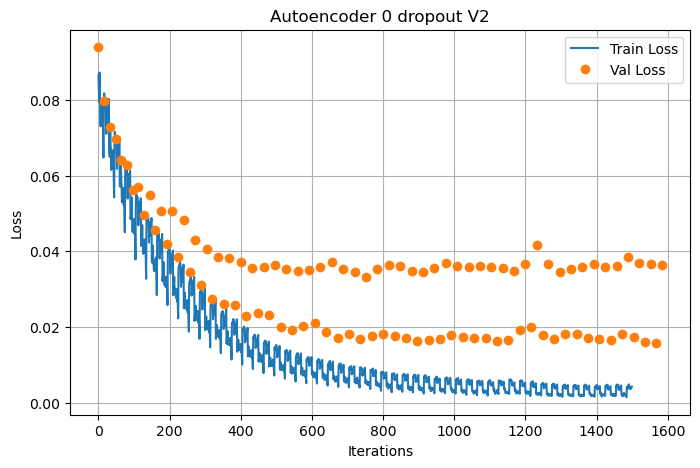

In [9]:
plt.figure(figsize=(8, 5))
plt.grid()
plt.plot(losses, label='Train Loss')
plt.plot(val_losses, 'o', label='Val Loss')
plt.xlabel('Iterations')
plt.title('Autoencoder 0 dropout V2')
plt.ylabel('Loss')
plt.legend()
plt.show()


if __name__ == '__main__':
    save_path = f'/kaggle/working/model_{model_name}_torch'
    torch.save(model, save_path)


In [10]:
if __name__ == '__main__':
    model.eval()

0.04291298985481262


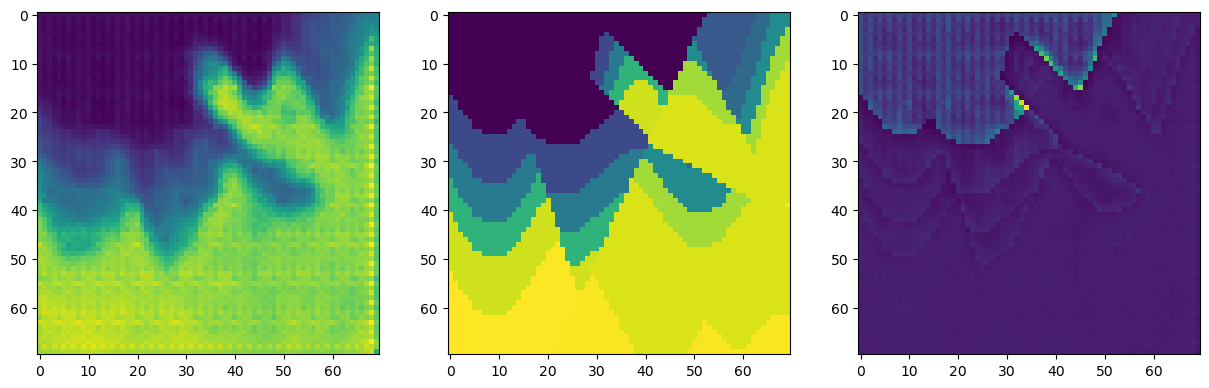

In [13]:
if __name__ == '__main__':
    i = 64
    entry_tensor = torch.Tensor(data[i].reshape(-1, 5, 1000,70)).to(device)
    entry = model(entry_tensor).cpu().detach().numpy()
    print(mean_absolute_error(target[i].reshape(70,70), entry.reshape(70,70)))
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    axs[2].imshow(entry.reshape(70,70)/target[i].reshape(70,70))
    axs[1].imshow(target[i].reshape(70,70))
    axs[0].imshow(entry.reshape(70,70))